<a href="https://colab.research.google.com/github/ismailerbas/Projects-in-Machine-Learning-and-AI/blob/main/projectreport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Problem


As in all organs in the body, tumors arise from cells in the brain. Usually, cells develop, grow, age, or die, and new cells are made instead. However, in abnormal situations, when this production and destruction process starts to work differently, when the cells that are not needed start to be made or because the cells that are made do not die on time, the unnecessary excess cell accumulation begins to cluster so that a formation called a tumor emerges in that organ, which is called a tumor. Magnetic Resonance Imaging (MRI) is the best technique to detect brain tumors [1]. There are three different tumor classes in this dataset. 

  The first one is the meningioma tumor. Meningioma tumor is usually noncancerous. Unfortunately, it isn't clear what causes a cell to turn into a meningioma tumor. There will be some symptoms (changes in vision, headaches, hearing loss, and seizures) [1].

  The second one is the pituitary tumor. This tumor is also noncancerous. They grow up in the pituitary gland, and fortunately, they do not spread beyond the skull.
The consequence of having a giant pituitary tumor is it can damage the brain and nerves by pressing upon them. Its common symptoms are vision changes and headaches. Occasionally it might cause sexual dysfunction and interfere with menstrual cycles [1].

 The third one is the glioma tumor. Glioma tumor forms in the brain and spinal cord. Its common symptoms are headaches, seizures, irritability, vomiting, visual difficulties, and weakness or numbness of the extremities [1].

It is tough to differentiate these tumors from one other and spot them. Only experienced neurosurgeons can analyze the MRI images, and unfortunately, developing or underdeveloped countries might not have enough experienced neurosurgeons. So using machine learning to classify if there is a tumor and which type of tumor it is, if there is one, is an excellent way. It can be cheap and robust at the same time. In this project, we will train and test the data on different models (CNN, different transfer learning models, Unet, and Vision transformers) and compare the results. 



The dataset link is : https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


[1] DeAngelis, Lisa M. "Brain tumors." New England journal of medicine 344.2 (2001): 114-123.

Setting up Libraries

In [ ]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
import os 
import keras 
from keras.models import Sequential, load_model
from keras.layers import Dense,Dropout,Conv2D, MaxPooling2D, Normalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization, Lambda, Input, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop ,Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import random
import shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import plotly.express as px

The data


In [ ]:
Training_dataset = "/content/drive/My Drive/mlp/project/Training" # I downloaded the dataset to my google drive to use it more easily
Test_dataset = "/content/drive/My Drive/mlp/project/Testing"

In [ ]:
# We will visualize some of the images next

<Figure size 432x288 with 0 Axes>

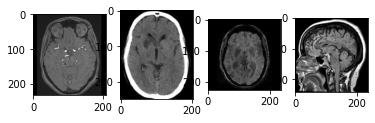

<Figure size 432x288 with 0 Axes>

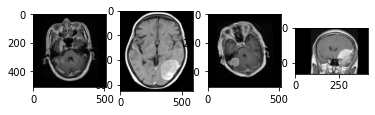

<Figure size 432x288 with 0 Axes>

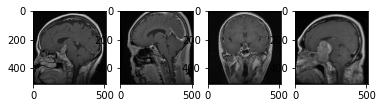

<Figure size 432x288 with 0 Axes>

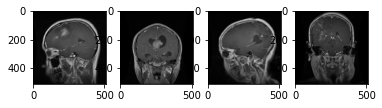

In [ ]:
import glob
fig = plt.figure()      # Here we will create a figure and show 4 images of tumorless brain images
fig.suptitle('no_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/no_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1
  
fig = plt.figure()      # Here we will create a figure and show 4 MRI images of meningioma_tumor
fig.suptitle('meningioma_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/meningioma_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1
  
fig = plt.figure()      # Here we will create a figure and show 4 MRI images of pituitary_tumor 
fig.suptitle('pituitary_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/pituitary_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1
fig = plt.figure()      # Here we will create a figure and show 4 MRI images of glioma_tumor
fig.suptitle('glioma_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/glioma_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1

In [ ]:

classes_info = {}
classes = sorted(os.listdir(Training_dataset))
for name in classes:
    classes_info[name] = len(os.listdir(Training_dataset + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05)
fig.show()

{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


In [ ]:
# We can see that no tumor class has 395 images and others have around same amount of images.

In [ ]:
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"] # We define the classes here 

In [ ]:
IMG_SIZE = 150 # We will resize the images to 150x150 because unfortunately colab cannot handle bigger images


In [ ]:
training_data = []

def create_training_data(): # Here we will import the data. For CNN model we will use Grayscale images and we will append labels to use as classes.
    for category in CATEGORIES:
        path = os.path.join(Training_dataset,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
test_data = []

def create_test_data(): # we will import the test data seperately and use the labels for the classes.
    for category in CATEGORIES:
        path = os.path.join(Test_dataset,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                test_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()
create_test_data()

In [ ]:
X = [] # here we seperate the labels from images and assign them to train and tests. We also normalize the images between 0-255 and reshape it to Convolution layer's input shape
yt = []
for features,label in training_data:
    X.append(features)
    yt.append(label)
X = np.array(X)
X = X/255.0  
X = X.reshape(-1,150,150,1)
X_train=X

X = []
y = []
for features,label in test_data:
    X.append(features)
    y.append(label)
X = np.array(X)
X = X/255.0  
X = X.reshape(-1,150,150,1)
X_test=X

In [ ]:
from keras.utils.np_utils import to_categorical # Here we convert the classes labels into categorical for the model to use 
yt = to_categorical(yt, num_classes = 4)
Y_train=yt
y = to_categorical(y, num_classes = 4)
Y_test=y

In [ ]:
print("x_train shape",X_train.shape) # We can see that training data shape was 2870,150,150,1.
print("x_test shape",X_test.shape)# We will have 394 images for test 
print("y_train shape",Y_train.shape)
print("y_test shape",Y_test.shape)

x_train shape (2870, 150, 150, 1)
x_test shape (394, 150, 150, 1)
y_train shape (2870, 4)
y_test shape (394, 4)


In [ ]:
# Here we define CNN model using convolutional layers and max pooling layers. At the end we use flatten to convert from 2D to 1D and use dense layers
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)), # I used relu as activation functions for the layers
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax') # I used softmax layer here because it is a classification task.
])

In [ ]:
model.compile(loss='categorical_crossentropy',                       # Because it is a multiclass classification, I used categorical crossentropy for loss function and model will use accuracy as a metric
              optimizer=tf.keras.optimizers.Adam(lr=1e-3), # I use Adam for optimizer and set learning rate to 1e-3 after tuning period
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss',  # We will use early stopping to the model for preventing overfitting
                              patience = 5, # The patience value means that the model will stop if the validation loss repeats 5 times.
                              verbose = 0,
                              mode = 'auto')

callback = [
  
    [earlyStopping]
]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32.
          #  Here I defined 30 epochs but it might stop at some point before. We could increase the number of epochs but because we are using colab it takes too much time and colab stops working after some time.

Epoch 1/30
72/72 [==============================] - 90s 1s/step - loss: 1.0712 - accuracy: 0.4948 - val_loss: 2.2386 - val_accuracy: 0.1951
Epoch 2/30
72/72 [==============================] - 78s 1s/step - loss: 0.7032 - accuracy: 0.6982 - val_loss: 1.4465 - val_accuracy: 0.4826
Epoch 3/30
72/72 [==============================] - 75s 1s/step - loss: 0.4467 - accuracy: 0.8227 - val_loss: 1.8940 - val_accuracy: 0.4059
Epoch 4/30
72/72 [==============================] - 75s 1s/step - loss: 0.3184 - accuracy: 0.8754 - val_loss: 1.2198 - val_accuracy: 0.6672
Epoch 5/30
72/72 [==============================] - 75s 1s/step - loss: 0.2363 - accuracy: 0.9120 - val_loss: 1.4675 - val_accuracy: 0.6202
Epoch 6/30
72/72 [==============================] - 75s 1s/step - loss: 0.1615 - accuracy: 0.9399 - val_loss: 1.5823 - val_accuracy: 0.6568
Epoch 7/30
72/72 [==============================] - 77s 1s/step - loss: 0.1416 - accuracy: 0.9460 - val_loss: 1.2740 - val_accuracy: 0.6742
Epoch 8/30
72/72 [==

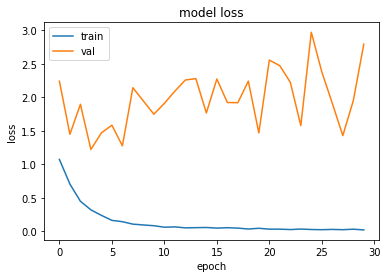

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# We can see that the cnn overfits by looking to the losses. 

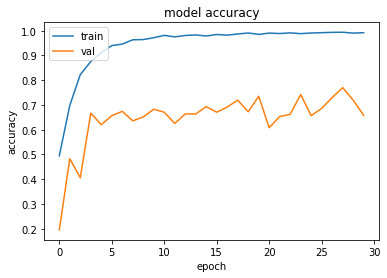

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# We can see that the accuracy of the train set is almost 100 and the validation accuracy is around 70, this is an indication of overfitting, model will probably won't perform as good as training for test set.  

In [ ]:
prediction=model.predict(X_test)

prediction = np.argmax(prediction ,axis =1)

testy=np.argmax(Y_test ,axis =1)
print('Classification Report')
target_names = CATEGORIES
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 3s 239ms/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.20      0.33       100
meningioma_tumor       0.65      1.00      0.79       115
        no_tumor       0.75      1.00      0.86       105
 pituitary_tumor       0.91      0.68      0.78        74

        accuracy                           0.74       394
       macro avg       0.80      0.72      0.69       394
    weighted avg       0.79      0.74      0.69       394



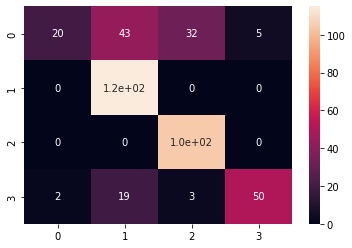

In [ ]:
import seaborn as sns
confusion_matrix = confusion_matrix(testy, prediction)
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# As we predicted the model is not as good as predicting classes in training and validation sets. There are several factors that can cause problem with model learning. 
# The image is reshaped and we might be loosing some information by reshaping it. 
# We can generate new images using augmentation methods, Gans, or vaes.
# We can improve the model by one of the using transfer learning models. Which can be an improvement.
# Class 0 was glioma_tumor, class 1 was meningioma_tumor, class 2 was no_tumor, and class 3 was pituitary_tumor.
# From confusion matrix we can see that class 0 was mistaken with all of the clases and model was could not learn to seperate it from others. For class 1 and 2 however model was very sucessfull. 
# All of the meningioma_tumor was differentiated from other tumors and all no_tumor was classiied correctly.
# For no tumor we can understand why it was a successfull classification, because it was different than others, it did not have tumor. 
# Model was struggling on classification for class 3. It was mostly confused with class 1. Overfitting might play a great role in these classification results because the model learned some feature of classes 1 and 2 
# and whenever it saw that it misclassified the images. 


Transfer learning using InceptionV3

In [ ]:
# Next we try the transfer learning model Inception V3 and we will see how using this model improves the model performance

In [ ]:
training_data = "/content/drive/My Drive/mlp/project/Training"  # I downloaded the dataset to my google drive to use it more easily
testing_data ="/content/drive/My Drive/mlp/project/Testing" 

In [ ]:
# Here we will merge the dataset and their labels respectively. 
imagePaths = list(paths.list_images(training_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for training 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_train = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_train = np.array(labels) 

In [ ]:
# We will do the same steps for test data below 
imagePaths = list(paths.list_images(testing_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
Y_train.shape # As we can see here we have 2870 images in total and their shape is 150x150x3 RGB channels

(2870,)

In [ ]:
from keras.utils.np_utils import to_categorical # Here we convert the classes labels into categorical for the model to use 
Y_train= to_categorical(Y_train, num_classes = 4)
Y_test= to_categorical(Y_test, num_classes = 4)



In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the InceptionV3, I added two dense layers
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use categorical crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use model checkpoint to save the best model

In [ ]:
# We can see the full summary of our model below.

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 31,242,532
Trainable params: 9,439,748
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
72/72 [==============================] - 129s 2s/step - loss: 0.7516 - accuracy: 0.7243 - val_loss: 1.1044 - val_accuracy: 0.5889
Epoch 2/30
72/72 [==============================] - 120s 2s/step - loss: 0.3161 - accuracy: 0.8863 - val_loss: 0.9943 - val_accuracy: 0.6063
Epoch 3/30
72/72 [==============================] - 120s 2s/step - loss: 0.2065 - accuracy: 0.9386 - val_loss: 1.5386 - val_accuracy: 0.4077
Epoch 4/30
72/72 [==============================] - 120s 2s/step - loss: 0.1546 - accuracy: 0.9477 - val_loss: 0.9416 - val_accuracy: 0.6254
Epoch 5/30
72/72 [==============================] - 119s 2s/step - loss: 0.0938 - accuracy: 0.9834 - val_loss: 1.6926 - val_accuracy: 0.3537
Epoch 6/30
72/72 [==============================] - 135s 2s/step - loss: 0.0657 - accuracy: 0.9917 - val_loss: 1.3832 - val_accuracy: 0.5052
Epoch 7/30
72/72 [==============================] - 123s 2s/step - loss: 0.0510 - accuracy: 0.9961 - val_loss: 1.2025 - val_accuracy: 0.5436
Epoch 8/30
72

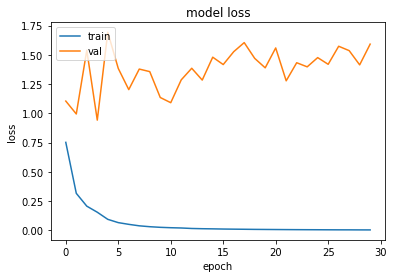

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# We can see that unfortunately this model is overfitting too the val loss and train loss are very different from each other

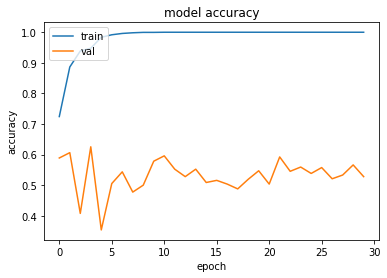

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Although the training accuracy was 1 the val accuracy is around 0.6.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 18s 1s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.60      1.00      0.75       105
meningioma_tumor       0.75      0.81      0.78        74
        no_tumor       0.83      0.63      0.72       115
 pituitary_tumor       0.82      0.42      0.56       100

        accuracy                           0.71       394
       macro avg       0.75      0.72      0.70       394
    weighted avg       0.75      0.71      0.70       394



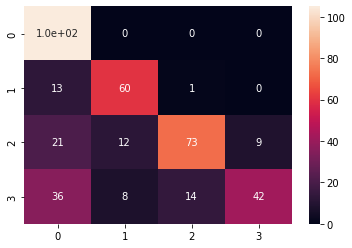

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# We can see that this model learned class 0 better than others and was slighly better than CNN. It was confused on classifying class 3 with class 0 mostly. 

Transfer learning using ResNet50

In [ ]:
training_data = "/content/drive/My Drive/mlp/project/gan/images/images" # I downloaded the dataset to my google drive to use it more easily
testing_data ="/content/drive/My Drive/mlp/project/Testing" 

In [ ]:
# Here we will merge the dataset and their labels respectively.
imagePaths = list(paths.list_images(training_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
# Here we will sdo the same for the test dataset.
imagePaths = list(paths.list_images(testing_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
from keras.utils.np_utils import to_categorical # Here we convert the classes labels into categorical for the model to use 
Y_train= to_categorical(Y_train, num_classes = 4)
Y_test= to_categorical(Y_test, num_classes = 4)



In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the ResNet50, I added two dense layers 
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use binary crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
# We can see the full summary of our model below.

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               26214912  
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 49,804,676
Trainable params: 26,216,964
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
72/72 [==============================] - 254s 3s/step - loss: 1.1258 - accuracy: 0.5640 - val_loss: 2.2030 - val_accuracy: 0.0000e+00
Epoch 2/30
72/72 [==============================] - 246s 3s/step - loss: 0.9640 - accuracy: 0.6812 - val_loss: 2.3671 - val_accuracy: 0.0000e+00
Epoch 3/30
72/72 [==============================] - 250s 3s/step - loss: 0.8800 - accuracy: 0.6990 - val_loss: 1.8584 - val_accuracy: 0.0087
Epoch 4/30
72/72 [==============================] - 326s 5s/step - loss: 0.8214 - accuracy: 0.7260 - val_loss: 1.8100 - val_accuracy: 0.0226
Epoch 5/30
72/72 [==============================] - 309s 4s/step - loss: 0.7791 - accuracy: 0.7365 - val_loss: 2.3523 - val_accuracy: 0.0052
Epoch 6/30
72/72 [==============================] - 266s 4s/step - loss: 0.7491 - accuracy: 0.7404 - val_loss: 2.1872 - val_accuracy: 0.0157
Epoch 7/30
72/72 [==============================] - 245s 3s/step - loss: 0.7209 - accuracy: 0.7509 - val_loss: 1.9299 - val_accuracy: 0.0436
Epoch

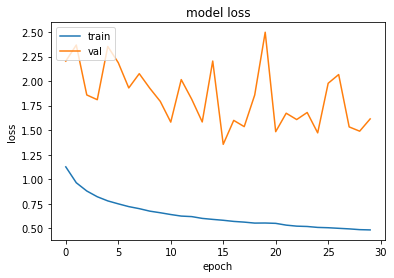

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

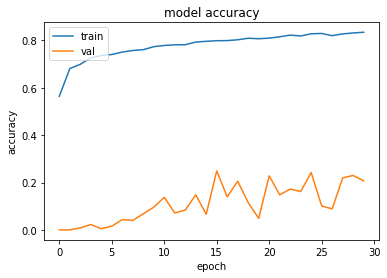

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 35s 3s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.32      0.76      0.45       105
meningioma_tumor       0.50      0.50      0.50        74
        no_tumor       0.74      0.20      0.32       115
 pituitary_tumor       0.38      0.15      0.22       100

        accuracy                           0.39       394
       macro avg       0.49      0.40      0.37       394
    weighted avg       0.49      0.39      0.36       394



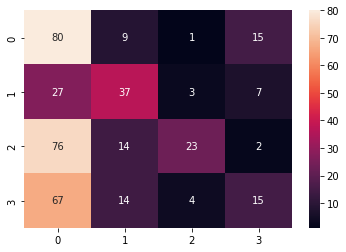

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# This model was mistaken about classifying every class and it seems it could not learn anything useful from the images. It was relatively good at classifying the class 0 but it was clearly overfitted.

Transfer learning using VGG16

In [ ]:
training_data = "/content/drive/My Drive/mlp/project/Training" # I downloaded the dataset to my google drive to use it more easily
testing_data ="/content/drive/My Drive/mlp/project/Testing" 

In [ ]:
# Here we will merge the dataset and their labels respectively.
imagePaths = list(paths.list_images(training_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
# Here we will merge test set and labels
imagePaths = list(paths.list_images(testing_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
from keras.utils.np_utils import to_categorical # Here we convert the classes labels into categorical for the model to use 
Y_train= to_categorical(Y_train, num_classes = 4)
Y_test= to_categorical(Y_test, num_classes = 4)



In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the VGG16, I added two dense layers in which last was a softmax layer for multiclass classification
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use binary crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
# We can see the full summary of our model below.

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 18,911,556
Trainable params: 4,196,868
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
72/72 [==============================] - 644s 9s/step - loss: 1.0295 - accuracy: 0.6416 - val_loss: 1.9208 - val_accuracy: 0.0017
Epoch 2/30
72/72 [==============================] - 659s 9s/step - loss: 0.7072 - accuracy: 0.7835 - val_loss: 1.7778 - val_accuracy: 0.0331
Epoch 3/30
72/72 [==============================] - 652s 9s/step - loss: 0.5610 - accuracy: 0.8314 - val_loss: 1.6655 - val_accuracy: 0.0889
Epoch 4/30
72/72 [==============================] - 656s 9s/step - loss: 0.4802 - accuracy: 0.8541 - val_loss: 1.5288 - val_accuracy: 0.1690
Epoch 5/30
72/72 [==============================] - 638s 9s/step - loss: 0.4302 - accuracy: 0.8611 - val_loss: 1.4221 - val_accuracy: 0.2387
Epoch 6/30
72/72 [==============================] - 630s 9s/step - loss: 0.3931 - accuracy: 0.8798 - val_loss: 1.2291 - val_accuracy: 0.3467
Epoch 7/30
72/72 [==============================] - 634s 9s/step - loss: 0.3618 - accuracy: 0.8872 - val_loss: 1.4624 - val_accuracy: 0.1969
Epoch 8/30
72

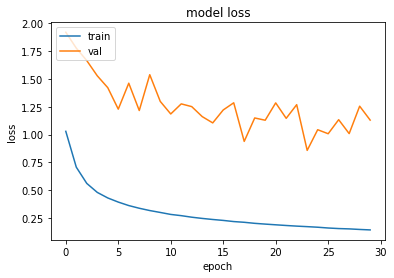

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

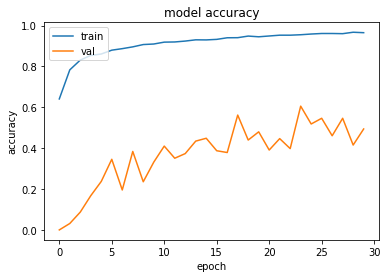

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 87s 7s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.52      0.99      0.68       105
meningioma_tumor       0.69      0.77      0.73        74
        no_tumor       0.79      0.54      0.64       115
 pituitary_tumor       0.69      0.22      0.33       100

        accuracy                           0.62       394
       macro avg       0.67      0.63      0.60       394
    weighted avg       0.67      0.62      0.59       394



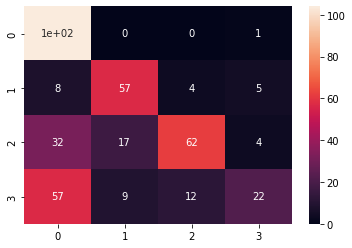

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# We can see that this model was closer to the InceptionV3. However it performed worse than InceptionV3. This was also mostly mistaken classifying class 3 with class 0

Transfer learning using Xception

In [ ]:
training_data = "/content/drive/My Drive/mlp/project/Training" # I downloaded the dataset to my google drive to use it more easily
testing_data ="/content/drive/My Drive/mlp/project/Testing" 

In [ ]:
# Here we will merge the dataset and their labels respectively.
imagePaths = list(paths.list_images(training_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
# Here we will do the same for the test set
imagePaths = list(paths.list_images(testing_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train= to_categorical(Y_train, num_classes = 4)
Y_test= to_categorical(Y_test, num_classes = 4)


In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the Xception, I added two dense layers as we did above for the cnn model
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use binary crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               26214912  
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 47,078,444
Trainable params: 26,216,964
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
72/72 [==============================] - 252s 3s/step - loss: 0.5583 - accuracy: 0.7970 - val_loss: 1.4707 - val_accuracy: 0.3397
Epoch 2/30
72/72 [==============================] - 245s 3s/step - loss: 0.2621 - accuracy: 0.9120 - val_loss: 1.5139 - val_accuracy: 0.3850
Epoch 3/30
72/72 [==============================] - 247s 3s/step - loss: 0.1771 - accuracy: 0.9482 - val_loss: 0.8222 - val_accuracy: 0.6777
Epoch 4/30
72/72 [==============================] - 250s 3s/step - loss: 0.1291 - accuracy: 0.9647 - val_loss: 1.0368 - val_accuracy: 0.5871
Epoch 5/30
72/72 [==============================] - 244s 3s/step - loss: 0.0911 - accuracy: 0.9843 - val_loss: 1.2803 - val_accuracy: 0.4948
Epoch 6/30
72/72 [==============================] - 245s 3s/step - loss: 0.0710 - accuracy: 0.9891 - val_loss: 0.8308 - val_accuracy: 0.6864
Epoch 7/30
72/72 [==============================] - 243s 3s/step - loss: 0.0576 - accuracy: 0.9935 - val_loss: 1.0189 - val_accuracy: 0.6307
Epoch 8/30
72

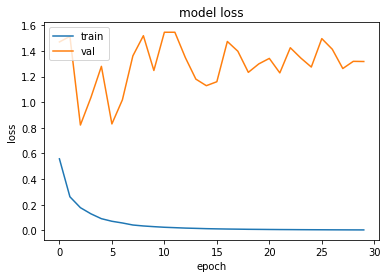

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

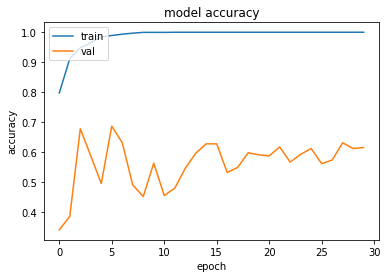

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 31s 2s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.66      1.00      0.80       105
meningioma_tumor       0.88      0.89      0.89        74
        no_tumor       0.72      0.70      0.71       115
 pituitary_tumor       0.73      0.36      0.48       100

        accuracy                           0.73       394
       macro avg       0.75      0.74      0.72       394
    weighted avg       0.74      0.73      0.71       394



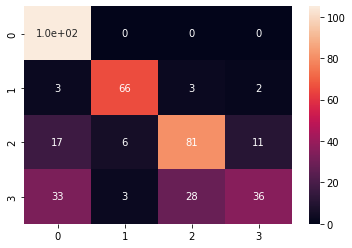

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# Unfortunately all of the models for transfer learning were overfitting and they were good at defining class 0 like the one above but other classes were not getting clasified correctly. 
# We can solve this issue by trying some different techniques. We can use regularizers and dropout layers to overcome overfitting. We can also increase the resolution of images so the tumor can be seen more. 
# Unfortunately I could not do any of them because adding regularizations increase the training time and with colab it is very hard to train for a long time. Also colab kernel keeps restarting if we increase the resolution of the ımages.
# So these solutions can be used on a decent computer wıth a good gpu. Every epoch took around 10 mins usually. This is a long time to train on colab.
# We can also generate new images using GAN. We will try it below. 
# Lastly  we can use different models like Unet and Vision transformers. 

Unet

In [ ]:
# U-net was originally invented and first used for biomedical image segmentation. Its architecture can be broadly thought of as an encoder network followed by a decoder network. 
# Although it was widely used for segmentation, it can be used for classification because the model can find the differences in each class and can separate the classes. I modified a Unet model designed for classification.
# The original model can be found here: https://github.com/Walshj73/UNET-Tumour-Segmentation/blob/main/UNet/Train.py

In [ ]:
training_data = "/content/drive/My Drive/mlp/project/Training" # I downloaded the dataset to my google drive to use it more easily
testing_data ="/content/drive/My Drive/mlp/project/Testing" 

In [ ]:
# Here we will merge the dataset and their labels respectively.
imagePaths = list(paths.list_images(training_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
# Here we will do same thing for the test data
imagePaths = list(paths.list_images(testing_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train= to_categorical(Y_train, num_classes = 4)
Y_test= to_categorical(Y_test, num_classes = 4)



In [ ]:
def conv_block(x, num_filters): # Here we define the conv blocks 
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def build_model(): # We can use for loops to build the model and will create encoder and decoder separetely. 
    size = 128
    num_filters = [16, 32, 48, 64]
    inputs = Input(shape=(size, size, 3))

    skip_x = []
    x = inputs

    # Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    # Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    # Decoder
    for i, f, in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    # Output
    x = Flatten()(x) # The original model was outputting an image. But we need a classification so I changed the end of the model.   
    x = Dense(512, activation='relu')(x)
    x = Dense(4, activation="softmax")(x)
    
    return Model(inputs, x)


if __name__ == "__main__":
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use categorical crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=15, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 15 epochs but it might stop at some point.

Epoch 1/15
72/72 [==============================] - 561s 8s/step - loss: 0.7932 - accuracy: 0.7517 - val_loss: 1.7318 - val_accuracy: 0.0000e+00
Epoch 2/15
72/72 [==============================] - 524s 7s/step - loss: 0.2307 - accuracy: 0.9229 - val_loss: 1.6804 - val_accuracy: 0.0000e+00
Epoch 3/15
72/72 [==============================] - 523s 7s/step - loss: 0.0804 - accuracy: 0.9830 - val_loss: 2.3720 - val_accuracy: 0.0000e+00
Epoch 4/15
72/72 [==============================] - 521s 7s/step - loss: 0.0418 - accuracy: 0.9930 - val_loss: 2.4834 - val_accuracy: 0.0000e+00
Epoch 5/15
72/72 [==============================] - 523s 7s/step - loss: 0.0166 - accuracy: 0.9987 - val_loss: 2.1333 - val_accuracy: 0.0418
Epoch 6/15
72/72 [==============================] - 522s 7s/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 2.4722 - val_accuracy: 0.0732
Epoch 7/15
72/72 [==============================] - 520s 7s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.6721 - val_accuracy: 0.32

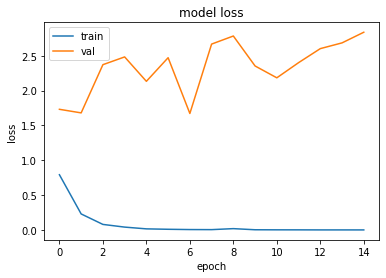

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

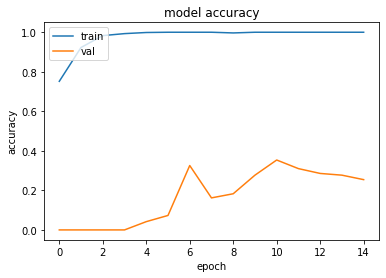

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 18s 1s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.44      1.00      0.61       105
meningioma_tumor       0.77      0.74      0.76        74
        no_tumor       0.97      0.50      0.66       115
 pituitary_tumor       0.73      0.19      0.30       100

        accuracy                           0.60       394
       macro avg       0.73      0.61      0.58       394
    weighted avg       0.73      0.60      0.58       394



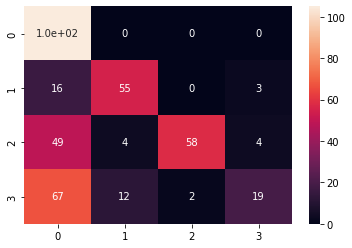

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# From this point forward we can see that the resolution of the images are not enough. This model was overfitted too and we get same results from this model too. 
# We can generate new data and try these models again, so we will see the results when there is more data.

Vision Transformer


In [ ]:
# Lastly we will try Vision Transformer model. However, recent studies shown that Vision transformers outperform CNNs in image classification tasks, by using the self-attention mechanism it can aggregate global features [1].
# [1] https://ai-scholar.tech/en/articles/transformer/transformer-vs-cnn

In [ ]:
!pip install -U tensorflow-addons # We will use tensorflows addon library in this model. The model can be seen in https://keras.io/examples/vision/image_classification_with_vision_transformer/



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.9 MB/s 


In [ ]:
import tensorflow_addons as tfa
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
tf.config.list_physical_devices()  # This code shows available devices in present computer. Because we are using colab we don't have the GPU which will be a problem with transformer model

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


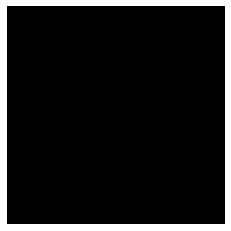

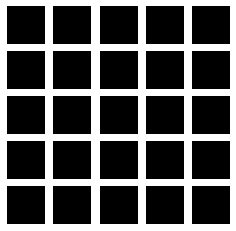

In [ ]:
import matplotlib.pyplot as plt # We will plot the image here. We will divide the image into patches and use it in transformer model. 
#This can be a solution to our resolution problem but we will not be able to make it work on colab because of the memory issue.

plt.figure(figsize=(4, 4))
image = Xtrain[np.random.choice(range(Xtrain.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Also because we are reshaping the image to 32x32, I think that the image looses all the features. It shows black image after image manipulation which is not needed.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    
    # Create patches.
    patches = Patches(patch_size)(Xtrain)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=Xtrain,
        y=Ytrain,
        batch_size=32,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(Xtest, Ytest)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

num_classes = 4
input_shape = (32, 32, 3)
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

ResourceExhaustedError: ignored

In [ ]:
# Unfortunately as seen above we get out of memory error and there is no fix for it on colab. We have to use a better computer for this model to work.

GAN


In [ ]:
"""
Generative Adversarial Networks (GANs) are commonly used to generate synthetic data similar to real-world data they have been trained on [1]. A GAN model was used to increase the number
of images the models can train. The GAN model used was FastGAN [2]. According to the creator of the FastGAN, it can converge on %80 of over 20 different datasets, and it is helpful in medical imaging. 
Usually, medical image datasets are small in quantity, and it is difficult for the models to learn from such amounts. Therefore using FastGAN to generate more data will help with training models.

Each training took 7 hours to finish with 50000 iterations. I only trained the model on training images and test images were unknown to the model. Although it took long time to finish training, generating images were faster. I generated 10000 images for each class because I am using Colab and it wouldn't handle 
more data. I mixed real images with generated images later. 6838 images were used for training. It was tested on the same test dataset that was used above. 

 

In [ ]:
# Representative results of the generation can be seen in the figure below:

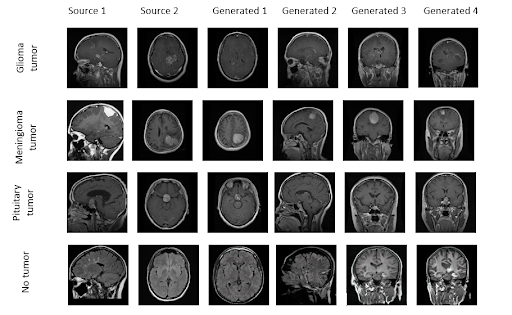

In [ ]:
"""
We can see the results for each model in above figure. As shown in Figure, the results of synthetic data generation are mixed. In columns generated 1,
2, and 3, the images closely resemble the source images. This shows how good GAN was generating  the images and we can see the differences in every row. However images should ideally
be filtered by an expert. Because these are medical images and there should not be any mistake on classification. So after generating good amount of images and filtering the images it can be used more effectively in the training.
"""

[1] I. Goodfellow et al., "Generative adversarial nets," Advances in neural information processing systems, vol. 27, 2014.
[2] https://github.com/odegeasslbc/FastGAN-pytorch

The data


In [ ]:
Training_dataset = "/content/drive/My Drive/mlp/project/gan/imagesmerged/images/" # I downloaded the dataset to my google drive to use it more easily
Test_dataset = "/content/drive/My Drive/mlp/project/Testing"

In [ ]:
# We will visualize some of the images next

Text(0.5, 0.98, 'no_tumor')

Text(0.5, 0.98, 'meningioma_tumor')

Text(0.5, 0.98, 'pituitary_tumor')

Text(0.5, 0.98, 'glioma_tumor')

<Figure size 432x288 with 0 Axes>

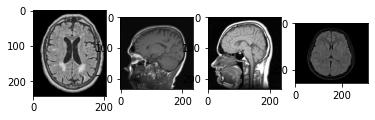

<Figure size 432x288 with 0 Axes>

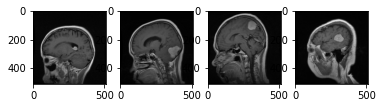

<Figure size 432x288 with 0 Axes>

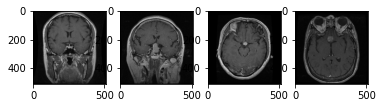

<Figure size 432x288 with 0 Axes>

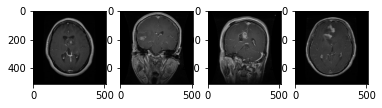

In [ ]:
import glob
fig = plt.figure()      # Here we will create a figure and show 4 images of tumorless brain images
fig.suptitle('no_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/no_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1
  
fig = plt.figure()      # Here we will create a figure and show 4 MRI images of meningioma_tumor
fig.suptitle('meningioma_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/meningioma_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1
  
fig = plt.figure()      # Here we will create a figure and show 4 MRI images of pituitary_tumor 
fig.suptitle('pituitary_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/pituitary_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1
fig = plt.figure()      # Here we will create a figure and show 4 MRI images of glioma_tumor
fig.suptitle('glioma_tumor')
f, axarr = plt.subplots(1,4) 
k=0
# We will use glob library to import whole folder 
for img_path in glob.glob(Training_dataset + '/glioma_tumor/*'):
  if k<4:
    axarr[k].imshow(mpimg.imread(img_path))
    k=k+1

In [ ]:
# From these images we can see that no tumor is easily differentiable from tumorus images. However at this resolution seperating tumors from each other is not very possible for a human. 

In [ ]:
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [ ]:

classes_info = {}
classes = sorted(os.listdir(Training_dataset))
for name in classes:
    classes_info[name] = len(os.listdir(Training_dataset + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05)
fig.show()

{'glioma_tumor': 1818, 'meningioma_tumor': 1814, 'no_tumor': 1387, 'pituitary_tumor': 1819}


In [ ]:
# Wecan see the portions of the classes above. After generating 1000 more no tumor class portion was increased to 20.3%

In [ ]:
IMG_SIZE=150

In [ ]:
training_data = []

def create_training_data(): # Here we will import the data. For CNN model we will use Grayscale images and we will append labels to use as classes.
    for category in CATEGORIES:
        path = os.path.join(Training_dataset,category)
        print(path)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
                
            except Exception as e:
                print(e)
                pass
test_data = []

def create_test_data(): # we will import the test data seperately and use the labels for the classes.
    for category in CATEGORIES:
        path = os.path.join(Test_dataset,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                test_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()
create_test_data()


/content/drive/My Drive/mlp/project/gan/imagesmerged/images/glioma_tumor
/content/drive/My Drive/mlp/project/gan/imagesmerged/images/meningioma_tumor
/content/drive/My Drive/mlp/project/gan/imagesmerged/images/no_tumor
/content/drive/My Drive/mlp/project/gan/imagesmerged/images/pituitary_tumor


In [ ]:
X = [] # here we seperate the labels from images and assign them to train and tests. We also normalize the images between 0-255 and reshape it to Convolution layer's input shape
yt = []
for features,label in training_data:
    X.append(features)
   
    yt.append(label)
X = np.array(X)
X = X/255.0  
X = X.reshape(-1,150,150,1)
X_train=X

X = []
y = []
for features,label in test_data:
    X.append(features)
    y.append(label)
X = np.array(X)
X = X/255.0  
X = X.reshape(-1,150,150,1)
X_test=X

In [ ]:
from keras.utils.np_utils import to_categorical # Here we convert the classes labels into categorical for the model to use 
yt = to_categorical(yt, num_classes = 4)
Y_train=yt
y = to_categorical(y, num_classes = 4)
Y_test=y

In [ ]:
print("x_train shape",X_train.shape) # We can see that training data shape was 6838,150,150,1.
print("x_test shape",X_test.shape)# We will have 394 images for test 
print("y_train shape",Y_train.shape)
print("y_test shape",Y_test.shape)

x_train shape (6838, 150, 150, 1)
x_test shape (394, 150, 150, 1)
y_train shape (6838, 4)
y_test shape (394, 4)


In [ ]:
# Here we define CNN model using convolutional layers and max pooling layers. At the end we use flatten to convert from 2D to 1D and use dense layers
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)), # I used relu as activation functions for the layers
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax') # I used softmax layer here because it is a classification task.
])

In [ ]:
model.compile(loss='categorical_crossentropy',                       # Because it is a multiclass classification, I used categorical crossentropy for loss funtion and model will use accuracy as a metric
              optimizer=tf.keras.optimizers.Adam(lr=1e-3), # I use Adam for optimizer and set learning rate to 1e-3 after tuning period
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss',  # We will use early stopping to the model for preventing overfitting
                              patience = 5, # The patience value means that the model will stop if the validation loss repeats 5 times.
                              verbose = 0,
                              mode = 'auto')

callback = [
  
    [earlyStopping]
]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32.
          #  Here I defined 30 epochs but it might stop at some point before 

Epoch 1/30
171/171 [==============================] - 192s 1s/step - loss: 0.6049 - accuracy: 0.7494 - val_loss: 0.5992 - val_accuracy: 0.7968
Epoch 2/30
171/171 [==============================] - 185s 1s/step - loss: 0.2462 - accuracy: 0.9020 - val_loss: 1.0330 - val_accuracy: 0.6732
Epoch 3/30
171/171 [==============================] - 187s 1s/step - loss: 0.1551 - accuracy: 0.9410 - val_loss: 1.7151 - val_accuracy: 0.5461
Epoch 4/30
171/171 [==============================] - 189s 1s/step - loss: 0.1044 - accuracy: 0.9622 - val_loss: 1.0380 - val_accuracy: 0.7376
Epoch 5/30
171/171 [==============================] - 182s 1s/step - loss: 0.0761 - accuracy: 0.9707 - val_loss: 1.2453 - val_accuracy: 0.6754
Epoch 6/30
171/171 [==============================] - 187s 1s/step - loss: 0.0557 - accuracy: 0.9821 - val_loss: 2.2593 - val_accuracy: 0.5746
Epoch 7/30
171/171 [==============================] - 188s 1s/step - loss: 0.0418 - accuracy: 0.9843 - val_loss: 0.7861 - val_accuracy: 0.7705

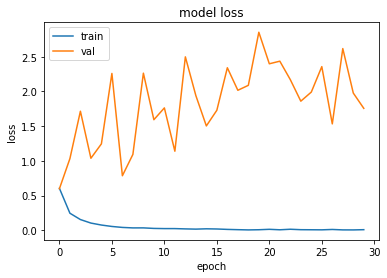

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# We can see that the cnn overfits by looking to the losses. 

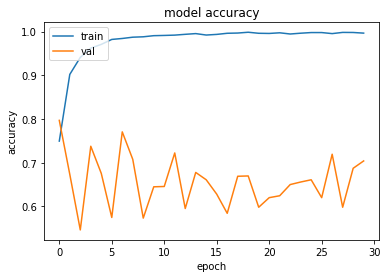

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
prediction=model.predict(X_test)

prediction = np.argmax(prediction ,axis =1)

testy=np.argmax(Y_test ,axis =1)
print('Classification Report')
target_names = CATEGORIES
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 3s 239ms/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.18      0.30       100
meningioma_tumor       0.54      0.99      0.70       115
        no_tumor       0.66      1.00      0.80       105
 pituitary_tumor       1.00      0.03      0.05        74

        accuracy                           0.61       394
       macro avg       0.76      0.55      0.46       394
    weighted avg       0.74      0.61      0.50       394



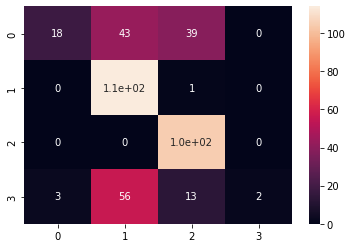

In [ ]:
import seaborn as sns
confusion_matrix = confusion_matrix(testy, prediction)
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# Unfortunately generating images with GAN doesn't seem to be the solution in this case. We got almost the same result for the CNN with or without GAN. 
# It is curious that CNN network separates class 1 and class 2 successfully and transfer learning models can only classify class 0 successfully. 
# This could mean that the structure after the layers of the transfer learning should be improved.    

In [ ]:
# Next we try the transfer learning model Inception V3 and we will see how using this model improves the model performance

ResNet50

In [ ]:
training_data = "/content/drive/My Drive/mlp/project/gan/imagesmerged/images" # I downloaded the dataset to my google drive to use it more easily
testing_data ="/content/drive/My Drive/mlp/project/Testing" 

In [ ]:
# Here we will merge the dataset and their labels respectively.
imagePaths = list(paths.list_images(training_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
# We will load the test dataset here
imagePaths = list(paths.list_images(testing_data))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Here we change the color channels from BGR to RGB for consistency
    image = cv2.resize(image, (150, 150)) # We resize the image to 150x150 pixels. The shapes of the images are different from each other and this fixes the image sizes. 
    data.append(image)
    if label=="no_tumor":
      labels.append(0)    # We save the class labels for test 
    elif label=="pituitary_tumor":
      labels.append(1) 
    elif label=="meningioma_tumor":
      labels.append(2)  
    elif label=="glioma_tumor":
      labels.append(3) 
X_test = np.array(data) / 255.0   # Here we normalize the image and we change it to np array for more efficient use
Y_test = np.array(labels) 

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train= to_categorical(Y_train, num_classes = 4)
Y_test= to_categorical(Y_test, num_classes = 4)

In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150X150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the ResNet50, I added two dense layers 
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use categorical crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               26214912  
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 49,804,676
Trainable params: 26,216,964
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
102/102 [==============================] - 339s 3s/step - loss: 1.0111 - accuracy: 0.6128 - val_loss: 2.7674 - val_accuracy: 0.0000e+00
Epoch 2/30
102/102 [==============================] - 336s 3s/step - loss: 0.7541 - accuracy: 0.7634 - val_loss: 2.1387 - val_accuracy: 0.0135
Epoch 3/30
102/102 [==============================] - 333s 3s/step - loss: 0.6346 - accuracy: 0.8196 - val_loss: 1.9655 - val_accuracy: 0.0541
Epoch 4/30
102/102 [==============================] - 335s 3s/step - loss: 0.5518 - accuracy: 0.8516 - val_loss: 2.0572 - val_accuracy: 0.0455
Epoch 5/30
102/102 [==============================] - 337s 3s/step - loss: 0.4882 - accuracy: 0.8734 - val_loss: 2.2634 - val_accuracy: 0.0430
Epoch 6/30
102/102 [==============================] - 342s 3s/step - loss: 0.4427 - accuracy: 0.8909 - val_loss: 1.5891 - val_accuracy: 0.1880
Epoch 7/30
102/102 [==============================] - 340s 3s/step - loss: 0.4073 - accuracy: 0.8937 - val_loss: 2.1665 - val_accuracy: 0.

In [ ]:
# We can see that each epoch took around 6 minutes 

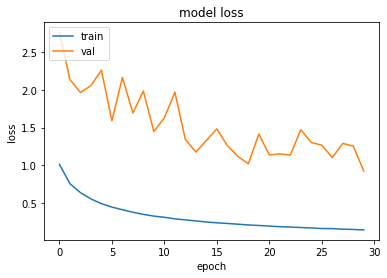

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

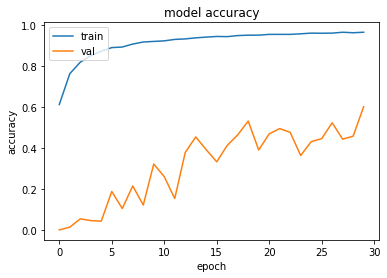

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# We can see the overfitting by checking the validation and training loss/accuracy. They have huge differences. Increasing epochs would be helpful on convergence but because of colab limitations I could not test more epochs.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 32s 2s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.36      0.89      0.51       105
meningioma_tumor       0.44      0.36      0.40        74
        no_tumor       0.25      0.13      0.17       115
 pituitary_tumor       0.71      0.10      0.18       100

        accuracy                           0.37       394
       macro avg       0.44      0.37      0.31       394
    weighted avg       0.43      0.37      0.31       394



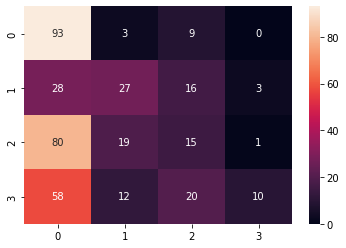

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

VGG16

In [ ]:
Y_train.shape # As we can see here we have 6838 images in total and their shape is 150x150 with RGB channels

(6838,)

In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the VGG16, I added two dense layers 
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use categorical crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 18,911,556
Trainable params: 4,196,868
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=10, verbose=1, shuffle=True) # I choose the batch size 10.   
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/10
171/171 [==============================] - 1351s 8s/step - loss: 0.4446 - accuracy: 0.8724 - val_loss: 4.8824 - val_accuracy: 0.0000e+00
Epoch 2/10
171/171 [==============================] - 1335s 8s/step - loss: 0.3401 - accuracy: 0.8971 - val_loss: 4.8714 - val_accuracy: 0.0000e+00
Epoch 3/10
171/171 [==============================] - 1334s 8s/step - loss: 0.2856 - accuracy: 0.9172 - val_loss: 4.2218 - val_accuracy: 0.0000e+00
Epoch 4/10
171/171 [==============================] - 1335s 8s/step - loss: 0.2508 - accuracy: 0.9280 - val_loss: 3.9861 - val_accuracy: 0.0000e+00
Epoch 5/10
171/171 [==============================] - 1338s 8s/step - loss: 0.2251 - accuracy: 0.9347 - val_loss: 3.8167 - val_accuracy: 0.0000e+00
Epoch 6/10
171/171 [==============================] - 1338s 8s/step - loss: 0.2057 - accuracy: 0.9397 - val_loss: 3.1922 - val_accuracy: 7.3099e-04
Epoch 7/10
171/171 [==============================] - 1335s 8s/step - loss: 0.1895 - accuracy: 0.9442 - val_loss

In [ ]:
# Unfortunately this model took around 20 minutes to train for each epoch and I had to reduce the epochs to 10 because time constraints of colab. I tried 30 epochs couple of times but could not get any results

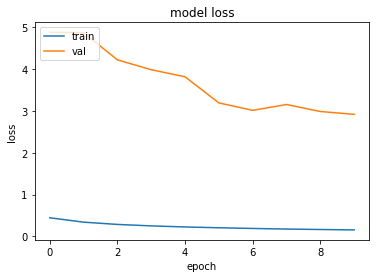

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

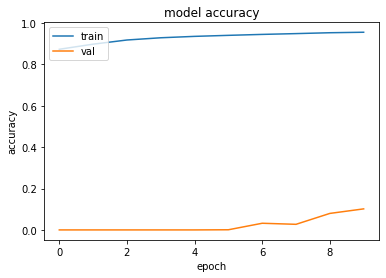

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Although the epochs are too small, we can see that it does not converge for the first ten epochs. For this model it is not fair to come to any conclusions without trying 30 or more epochs.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 79s 6s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.01      0.02       105
meningioma_tumor       0.73      0.77      0.75        74
        no_tumor       0.38      0.96      0.55       115
 pituitary_tumor       0.56      0.15      0.24       100

        accuracy                           0.46       394
       macro avg       0.67      0.47      0.39       394
    weighted avg       0.66      0.46      0.37       394



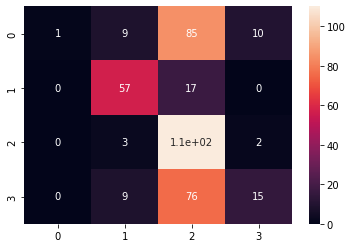

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

inception_v3

In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the InceptionV3, I added two dense layers as we did above for the cnn model
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use categorical crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
# We can see the full summary of our model above.

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 31,242,532
Trainable params: 9,439,748
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
102/102 [==============================] - 189s 2s/step - loss: 0.3176 - accuracy: 0.8931 - val_loss: 0.6829 - val_accuracy: 0.7076
Epoch 2/30
102/102 [==============================] - 172s 2s/step - loss: 0.0543 - accuracy: 0.9859 - val_loss: 0.2783 - val_accuracy: 0.9017
Epoch 3/30
102/102 [==============================] - 168s 2s/step - loss: 0.0250 - accuracy: 0.9969 - val_loss: 0.5623 - val_accuracy: 0.7936
Epoch 4/30
102/102 [==============================] - 170s 2s/step - loss: 0.0122 - accuracy: 0.9997 - val_loss: 0.3914 - val_accuracy: 0.8501
Epoch 5/30
102/102 [==============================] - 168s 2s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.3056 - val_accuracy: 0.8943
Epoch 6/30
102/102 [==============================] - 168s 2s/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.2443 - val_accuracy: 0.9226
Epoch 7/30
102/102 [==============================] - 168s 2s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3972 - val_accuracy: 0.8624

In [ ]:
# We can see that each epoch took aroun 3 mins

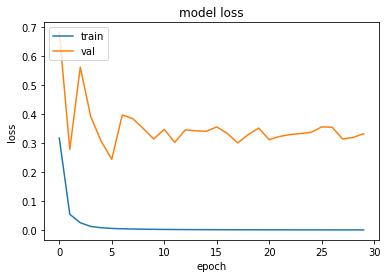

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

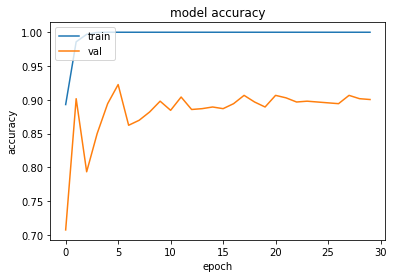

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# we can see that the loss and accuracies are converging seperately but it seems like this is one of the best results we have got.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 18s 1s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.47      0.90      0.61       105
meningioma_tumor       0.68      0.70      0.69        74
        no_tumor       0.49      0.43      0.46       115
 pituitary_tumor       0.69      0.09      0.16       100

        accuracy                           0.52       394
       macro avg       0.58      0.53      0.48       394
    weighted avg       0.57      0.52      0.47       394



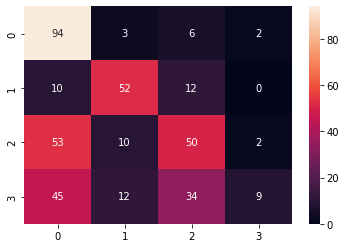

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# Unfortunately the model could not perform good on the test data. This means that the generated images are not really reflecting the real images and they need to be filtered by an expert. 
# It is very important to generate images as close to real images as possible to avoid such situations. Specially in medical projects it is very important to use good data. 

xception

In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))) # Here we define the model and remove the classifier part of the model by using "include_top=False", and we will specify out dataset image size 150x150.
for layer in pretrained_model.layers: # Here we will freeze the layer weights
        layer.trainable=False

model.add(pretrained_model)

In [ ]:
model.add(Flatten()) # After that we define the layers for our model after the InceptionV3, I added two dense layers at the end for classification. Last layer is softmax layer for the multiclass classification
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use binary crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 47,078,444
Trainable params: 26,216,964
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=30, verbose=1, shuffle=True) # I choose the batch size 32  
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/30
102/102 [==============================] - 338s 3s/step - loss: 0.2285 - accuracy: 0.9247 - val_loss: 0.3755 - val_accuracy: 0.8514
Epoch 2/30
102/102 [==============================] - 339s 3s/step - loss: 0.0419 - accuracy: 0.9920 - val_loss: 0.2123 - val_accuracy: 0.9226
Epoch 3/30
102/102 [==============================] - 339s 3s/step - loss: 0.0191 - accuracy: 0.9969 - val_loss: 0.3492 - val_accuracy: 0.8661
Epoch 4/30
102/102 [==============================] - 344s 3s/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.2596 - val_accuracy: 0.9029
Epoch 5/30
102/102 [==============================] - 341s 3s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.2696 - val_accuracy: 0.8956
Epoch 6/30
102/102 [==============================] - 340s 3s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2001 - val_accuracy: 0.9275
Epoch 7/30
102/102 [==============================] - 350s 3s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2404 - val_accuracy: 0.9177

In [ ]:
# We can see that each epoch took around 6 mins. 

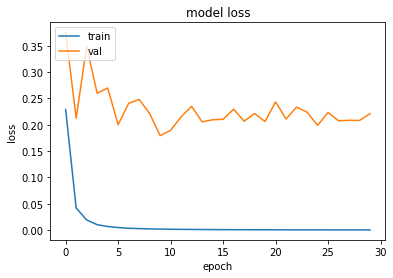

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

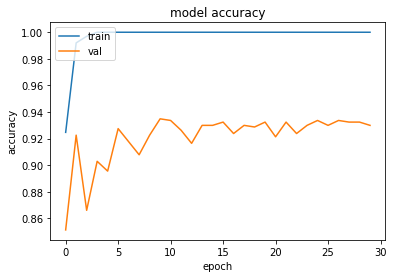

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 32s 2s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.52      0.94      0.67       105
meningioma_tumor       0.65      0.62      0.63        74
        no_tumor       0.58      0.59      0.59       115
 pituitary_tumor       0.94      0.15      0.26       100

        accuracy                           0.58       394
       macro avg       0.67      0.58      0.54       394
    weighted avg       0.67      0.58      0.53       394



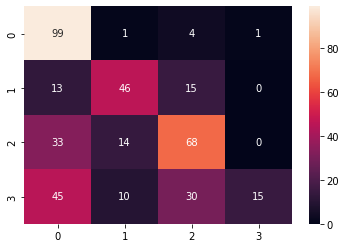

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

Unet

In [ ]:
def conv_block(x, num_filters): # Here we define the conv blocks 
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def build_model(): # We can use for loops to build the model and will create encoder and decoder separetely. 
    size = 128
    num_filters = [16, 32, 48, 64]
    inputs = Input(shape=(size, size, 3))

    skip_x = []
    x = inputs

    # Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    # Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    # Decoder
    for i, f, in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    # Output
    x = Flatten()(x) # The original model was outputting an image. But we need a classification so I changed the end of the model.   
    x = Dense(512, activation='relu')(x)
    x = Dense(4, activation="softmax")(x)
    
    return Model(inputs, x)


if __name__ == "__main__":
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(loss='categorical_crossentropy', # As cnn model we use categorical crossentropy for loss function and we can measure the model's performance using accuracy
              optimizer=tf.keras.optimizers.Adam(lr=1e-5), # We will use Adam optimizer and learning rate of 1e-3
              metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 5, 
                              verbose = 0,
                              mode = 'auto')
modelCheckPoint = ModelCheckpoint(filepath='/content/drive/My Drive/mlp/project/model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
callback = [
  
    [earlyStopping,modelCheckPoint]
] # We use earlystopping for prevention to overfitting and we will use modelcheckpoint to save the best model

In [ ]:
model.summary() # we can see the model here and we can see all the layers that we defined

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 16  64         ['conv2d_18[0][0]']              
 ormalization)                  )                                                           

In [ ]:
history=model.fit(X_train, Y_train,
          validation_split=0.2, # We split the training data by 80% train and 20% validation
          batch_size=32, epochs=15, verbose=1, shuffle=True) # I choose the batch size 15
          # Another hyperparameter is number of epechs which can be optimized with early stopping. Here I defined 30 epochs but it might stop at some point.

Epoch 1/15
171/171 [==============================] - 1215s 7s/step - loss: 0.5298 - accuracy: 0.8141 - val_loss: 6.3464 - val_accuracy: 0.0000e+00
Epoch 2/15
171/171 [==============================] - 1212s 7s/step - loss: 0.1334 - accuracy: 0.9594 - val_loss: 6.9997 - val_accuracy: 0.0000e+00
Epoch 3/15
171/171 [==============================] - 1232s 7s/step - loss: 0.0576 - accuracy: 0.9850 - val_loss: 6.8757 - val_accuracy: 0.0015
Epoch 4/15
171/171 [==============================] - 1235s 7s/step - loss: 0.0227 - accuracy: 0.9967 - val_loss: 5.7524 - val_accuracy: 0.0607
Epoch 5/15
171/171 [==============================] - 1228s 7s/step - loss: 0.0108 - accuracy: 0.9993 - val_loss: 6.5749 - val_accuracy: 0.0702
Epoch 6/15
171/171 [==============================] - 1252s 7s/step - loss: 0.0066 - accuracy: 0.9996 - val_loss: 5.7240 - val_accuracy: 0.1089
Epoch 7/15
171/171 [==============================] - 1501s 9s/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 5.2994 - val_a

In [ ]:
# We can see that each epoch took around 20 mins

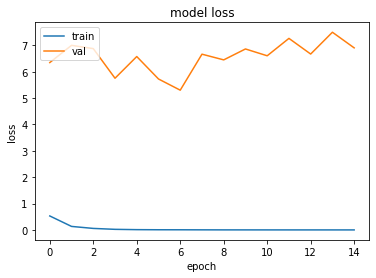

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

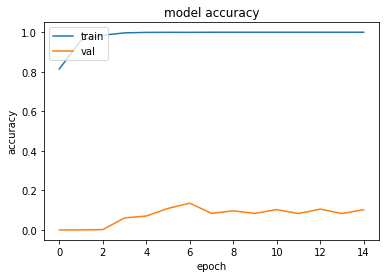

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Unfortunately Unet was overfitting too much and the loss is very high. It seems like altough it is good for segmentation it is not for the classification of medical images.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction=model.predict(X_test)
prediction = np.argmax(prediction ,axis =1)
testy=np.argmax(Y_test ,axis =1)
confusion_matrix = confusion_matrix(testy, prediction)
print('Classification Report')
target_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
print(classification_report(testy, prediction, target_names=target_names))

13/13 [==============================] - 18s 1s/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.03      0.06       105
meningioma_tumor       0.60      0.61      0.60        74
        no_tumor       0.41      0.99      0.58       115
 pituitary_tumor       0.61      0.23      0.33       100

        accuracy                           0.47       394
       macro avg       0.65      0.46      0.39       394
    weighted avg       0.65      0.47      0.38       394



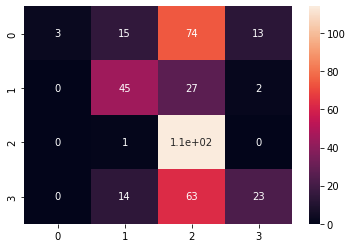

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot = True)

In this project, we used brain MRI images. There were four classes and three different tumor classes. Although experts can differentiate them efficiently, it is hard to find experts in every hospital in every country. A good machine-learning model can solve this problem and classify and segment tumors without needing an expert. The data and the model are essential for successful classification. Medical data are usually small in quantity, and because some models like transformers are data hungry, the data should be increased. However, increasing real image datasets is not always easy; some image generation techniques like GANs and VAEs can be used. As we can see above, there is one issue with this approach how do we know the quality of generated data? Usually, in these studies, an expert filters and rates the quality of the images before use. They must be as close as possible to the real images. That is why I chose FastGAN. According to the developer of FastGAN, it works very well at generating high-quality images. However, if we look at our results, we can see that it might not be a good choice for this data. Because the models were trained on these images and when we tried to test the performance on test data, which was original, we got low scores. That means overfitting and trying another method might increase the quality of the images.

On the other hand, the resolution of the images was too low (150x150). This resolution is not enough for the model to learn the details of the images; at this resolution, small tumors might get lost in the background. That can be solved by using a good computer with a good GPU. Another issue was that the computational resources required to train the models with generated data were considerably higher. This proved to be a huge issue since I was using google colab to train the models, and the models could not be trained for the high number of epochs. So many problems we had in this project can be solved using a computer. 

I tried hyperparameter tuning as much as possible, but we will need more tuning to improve the results. We can also use regularizers and dropout layers to avoid overfitting with a good resolution of the images and hyperparameter tuning. These eventually can be the solution for this dataset. We can also change the models' structure more and get better results. I used two dense layers for the transfer learning and Unet models, but this can be improved further.
Finally, we could not get vision transformers to work because of memory limitations. In the literature, vision transformers proved to perform better than CNN's [1].
[1] https://ai-scholar.tech/en/articles/transformer/transformer-vs-cnn 
